# Converts RGB, segmentation maps into COCO

In [ ]:
segm_dir = '/home/locobotm/AVD/habitat_data_with_seg/seg_p' # folder with *.npy segm maps to be converted to COCO
img_dir = "/home/locobotm/AVD/habitat_data_with_seg/rgb"
habitat_semantic_json = "/home/locobotm/AVD/habitat_data_with_seg/info_semantic.json"
coco_file_name = "coco_habitat_apart0.json" # Dumps annotations to this file

In [2]:
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import random
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from PIL import Image
from pycococreatortools import pycococreatortools
from IPython import embed
from tqdm import tqdm
from IPython.core.display import display, HTML


Bad key text.latex.unicode in file /home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You proba

In [3]:
fs = [x.split('.')[0] +'.jpg' for x in os.listdir(segm_dir)]
print("Creating COCO annotations for {} images".format(len(fs)))

Creating COCO annotations for 240 images


### Create coco json for `fs`

In [4]:
with open(habitat_semantic_json, "r") as f:
    habitat_semantic_data = json.load(f)

INFO = {}

LICENSES = [{}]

# create categories out of it
CATEGORIES = []
for obj_cls in habitat_semantic_data["classes"]:
    CATEGORIES.append({"id": obj_cls["id"], "name": obj_cls["name"], "supercategory": "shape"})
    if obj_cls['name'] in ('floor', 'wall', 'ceiling', 'wall-plug'):
        print(obj_cls['id'], obj_cls['name'])

coco_output = {
    "info": INFO,
    "licenses": LICENSES,
    "categories": CATEGORIES,
    "images": [],
    "annotations": [],
}

31 ceiling
40 floor
93 wall
95 wall-plug


In [5]:
count = 0
for x in tqdm(fs):
    image_id = int(x.split('.')[0])
    # load the annotation file
    try:
        prop_path = os.path.join(segm_dir, "{:05d}.npy".format(image_id))
        annot = np.load(prop_path).astype(np.uint8)
    except Exception as e:
        print(e)
        continue
        

    img_filename = "{:05d}.jpg".format(image_id)
    img = Image.open(os.path.join(img_dir, img_filename))
    image_info = pycococreatortools.create_image_info(
        image_id, os.path.basename(img_filename), img.size
    )

    coco_output["images"].append(image_info)

    # for each annotation add to coco format
    for i in np.sort(np.unique(annot.reshape(-1), axis=0)):
        try:
            category_info = {"id": habitat_semantic_data["id_to_label"][i], "is_crowd": False}
            if category_info["id"] < 1 or category_info["id"] in (31, 40, 93, 95):
                # Exclude wall, ceiling, floor, wall-plug
                continue
        except:
            print("label value doesnt exist for", i)
            continue
        binary_mask = (annot == i).astype(np.uint8)

        annotation_info = pycococreatortools.create_annotation_info(
            count, image_id, category_info, binary_mask, img.size, tolerance=2
        )
        if annotation_info is not None:
            coco_output["annotations"].append(annotation_info)
            count += 1
        
with open(coco_file_name, "w") as output_json:
    json.dump(coco_output, output_json)

100%|██████████| 240/240 [00:58<00:00,  4.09it/s]


# Visualize using detectron2 

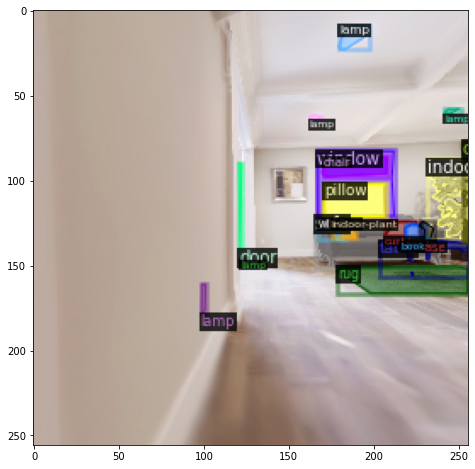

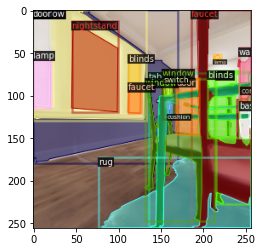

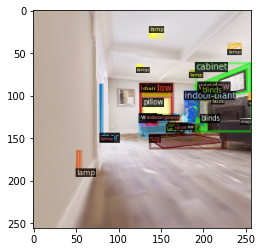

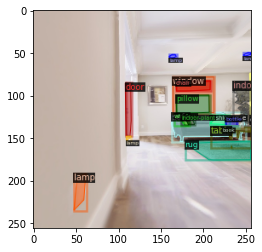

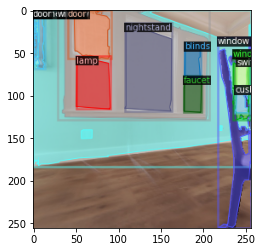

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer, ColorMode

DatasetCatalog.clear()
MetadataCatalog.clear()

register_coco_instances('foobar', {}, coco_file_name, img_dir)

MetadataCatalog.get('foobar')

dataset_dicts = DatasetCatalog.get('foobar')

plt.figure(figsize=(12 , 8))
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get('foobar'), scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    img = vis.get_image()
    plt.imshow(img)
    plt.show()